## Data description

There are 3 types of input features:

    Objective: factual information;
    Examination: results of medical examination;
    Subjective: information given by the patient.

Features:

    Age | Objective Feature | age | int (days)
    Height | Objective Feature | height | int (cm) |
    Weight | Objective Feature | weight | float (kg) |
    Gender | Objective Feature | gender | categorical code | gender_map={1:'female',2:'male'}
    Systolic blood pressure | Examination Feature | ap_hi | int |
    Diastolic blood pressure | Examination Feature | ap_lo | int |
    Cholesterol | Examination Feature | cholesterol | 1: normal, 2: above normal, 3: well above normal |
    Glucose | Examination Feature | gluc | 1: normal, 2: above normal, 3: well above normal |
    Smoking | Subjective Feature | smoke | binary |
    Alcohol intake | Subjective Feature | alco | binary |
    Physical activity | Subjective Feature | active | binary |
    Presence or absence of cardiovascular disease | Target Variable | cardio | binary | 0 = no 1= yes

All of the dataset values were collected at the moment of medical examination. 

## Initial data pre-processing

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly_express as px

In [2]:
df =  pd.read_csv("./Data/cardio_train.csv", sep = ";", index_col= "id")
df.head()

age  gender  height  weight  ap_hi  ap_lo  cholesterol  gluc  smoke  \
id                                                                          
0   18393       2     168    62.0    110     80            1     1      0   
1   20228       1     156    85.0    140     90            3     1      0   
2   18857       1     165    64.0    130     70            3     1      0   
3   17623       2     169    82.0    150    100            1     1      0   
4   17474       1     156    56.0    100     60            1     1      0   

    alco  active  cardio  
id                        
0      0       1       0  
1      0       1       1  
2      0       0       1  
3      0       1       1  
4      0       0       0

From the dataset description we find out that the age is in days, which is not that convenient for me, so I will transform this into age in years. I will make a copy of the dataset for this purpose.

In [3]:
df_years = df.rename(columns = {"age": "age_days"})
df_years["age_years"] = df_years["age_days"]/365

df_years.drop(["age_days"], axis = 1, inplace = True)
df_years.head()

gender  height  weight  ap_hi  ap_lo  cholesterol  gluc  smoke  alco  \
id                                                                         
0        2     168    62.0    110     80            1     1      0     0   
1        1     156    85.0    140     90            3     1      0     0   
2        1     165    64.0    130     70            3     1      0     0   
3        2     169    82.0    150    100            1     1      0     0   
4        1     156    56.0    100     60            1     1      0     0   

    active  cardio  age_years  
id                             
0        1       0  50.391781  
1        1       1  55.419178  
2        0       1  51.663014  
3        1       1  48.282192  
4        0       0  47.873973

Examining data for being accurate and consistent.

In [4]:
df_years.describe()

gender        height        weight         ap_hi         ap_lo  \
count  70000.000000  70000.000000  70000.000000  70000.000000  70000.000000   
mean       1.349571    164.359229     74.205690    128.817286     96.630414   
std        0.476838      8.210126     14.395757    154.011419    188.472530   
min        1.000000     55.000000     10.000000   -150.000000    -70.000000   
25%        1.000000    159.000000     65.000000    120.000000     80.000000   
50%        1.000000    165.000000     72.000000    120.000000     80.000000   
75%        2.000000    170.000000     82.000000    140.000000     90.000000   
max        2.000000    250.000000    200.000000  16020.000000  11000.000000   

        cholesterol          gluc         smoke          alco        active  \
count  70000.000000  70000.000000  70000.000000  70000.000000  70000.000000   
mean       1.366871      1.226457      0.088129      0.053771      0.803729   
std        0.680250      0.572270      0.283484      0.225568      0.397179   
min        1.000000      1.000000      0.000000      0.000000      0.000000   
25%        1.000000      1.000000      0.000000      0.000000      1.000000   
50%        1.000000      1.000000      0.000000      0.000000      1.000000   
75%        2.000000      1.000000      0.000000      0.000000      1.000000   
max        3.000000      3.000000      1.000000      1.000000      1.000000   

             cardio     age_years  
count  70000.000000  70000.000000  
mean       0.499700     53.339358  
std        0.500003      6.759594  
min        0.000000     29.583562  
25%        0.000000     48.394521  
50%        0.000000     53.980822  
75%        1.000000     58.430137  
max        1.000000     64.967123

* Age range is 29 - 64 years; There is some strange height and weight data, which is actually possible if studying Guinness World Records Book, but can probably cause problems with regression. So, I want to compute the **leverage statistic** for these columns; if the leverage statistic is high, I will gather this data in a separate dataset, to study them separately (will do it when analyzing BMI)

* ap_hi cannot be as high as 16020 and as low as -150. Same with ap_lo, so we'll have to clean these as well;



In [5]:
x = [(x - 165)**2 for x in df["height"]]
ss = np.sum(x)
lev = 1/70000 + (195 - 165)**2/ss
norm_lev = 2/70000
print(lev, norm_lev)

# very high leverage statistic for height 55
# создать функцию, которая собирает данные с leverage > norm_lev * 3.5 в отдельный dataset

0.00020387490820723196 2.857142857142857e-05


In [6]:
df.isna().sum()

age            0
gender         0
height         0
weight         0
ap_hi          0
ap_lo          0
cholesterol    0
gluc           0
smoke          0
alco           0
active         0
cardio         0
dtype: int64

In [7]:
print (True in df.duplicated())

False


### Data Cleaning

Here I:
- have changed negative ap_hi and ap_lo to positive;
- have added "0" to the end of otherwise plausible ap_hi and ap_lo values (e.g. 12 -> 120);
- have removed ap_lo < 20 which didn't seem possible to correct by muliplying by 10;
- have removed the rows with ap_hi > 250, as I haven't found any pattern in this mistake;
- have removed the rows with ap_lo = 0;
- have removed an odd "0" from ap_lo > 200 (e.g. 1000 -> 100);
- plotted weights and heights and made a conclusion, that weights < 35 and heights <100 are not trustworthy in this dataset.


In [8]:
df.loc[:, 'ap_hi']<30

id
0        False
1        False
2        False
3        False
4        False
         ...  
99993    False
99995    False
99996    False
99998    False
99999    False
Name: ap_hi, Length: 70000, dtype: bool

In [9]:
df.loc[df.loc[:, 'ap_hi']<0, :]

age  gender  height  weight  ap_hi  ap_lo  cholesterol  gluc  smoke  \
id                                                                             
6525   15281       1     165    78.0   -100     80            2     1      0   
22881  22108       2     161    90.0   -115     70            1     1      0   
29313  15581       1     153    54.0   -100     70            1     1      0   
34295  18301       1     162    74.0   -140     90            1     1      0   
36025  14711       2     168    50.0   -120     80            2     1      0   
50055  23325       2     168    59.0   -150     80            1     1      0   
66571  23646       2     160    59.0   -120     80            1     1      0   

       alco  active  cardio  
id                           
6525      0       1       0  
22881     0       1       0  
29313     0       1       0  
34295     0       1       1  
36025     0       0       1  
50055     0       1       1  
66571     0       0       0

In [10]:
df.loc[df.loc[:, 'ap_hi']<0, 'ap_hi']

id
6525    -100
22881   -115
29313   -100
34295   -140
36025   -120
50055   -150
66571   -120
Name: ap_hi, dtype: int64

In [11]:
for x in df.loc[df.loc[:, 'ap_hi']<0, 'ap_hi']:
    df.loc[df.loc[:, 'ap_hi']<0, 'ap_hi'] = abs(x)

df.loc[6525, :]


age            15281.0
gender             1.0
height           165.0
weight            78.0
ap_hi            100.0
ap_lo             80.0
cholesterol        2.0
gluc               1.0
smoke              0.0
alco               0.0
active             1.0
cardio             0.0
Name: 6525, dtype: float64

In [12]:
df.loc[df.loc[:, 'ap_hi']<25, :]

age  gender  height  weight  ap_hi  ap_lo  cholesterol  gluc  smoke  \
id                                                                             
815    21281       1     168    78.0     14     90            2     1      0   
1294   21867       2     175    70.0     14     90            3     1      0   
1360   18225       1     172    65.0     11     80            1     3      0   
2260   19201       1     165    66.0     12     80            1     1      0   
2301   22591       1     165    71.0     14     80            1     1      0   
...      ...     ...     ...     ...    ...    ...          ...   ...    ...   
98039  21217       1     160    59.0     12     80            1     1      0   
98213  18755       1     158    74.0     14     90            1     1      0   
98568  19107       1     154    77.0     14     90            1     1      0   
98743  15442       2     176    65.0     12     80            1     1      0   
99328  21243       1     155    69.0     13     90            1     3      0   

       alco  active  cardio  
id                           
815       0       1       1  
1294      0       1       1  
1360      0       1       0  
2260      0       1       0  
2301      0       1       1  
...     ...     ...     ...  
98039     0       1       0  
98213     0       1       1  
98568     0       1       0  
98743     0       1       0  
99328     0       1       1  

[181 rows x 12 columns]

In [13]:
for x in df.loc[df.loc[:, 'ap_hi']<25, 'ap_hi']:
    df.loc[df.loc[:, 'ap_hi']<25, 'ap_hi'] = x*10

In [14]:
df.loc[df.loc[:, 'ap_hi']<60, :]

Empty DataFrame
Columns: [age, gender, height, weight, ap_hi, ap_lo, cholesterol, gluc, smoke, alco, active, cardio]
Index: []

In [15]:
df.loc[df.loc[:, 'ap_hi']>250, :]

age  gender  height  weight  ap_hi  ap_lo  cholesterol  gluc  smoke  \
id                                                                             
2654   15116       1     160    60.0    902     60            1     1      0   
2845   22712       2     167    59.0    906      0            1     1      0   
6822   14425       1     168    63.0    909     60            2     1      0   
11089  21032       1     175    80.0  11500     90            1     1      0   
12710  18870       1     164    75.0   1420     80            2     1      0   
13616  22659       1     155    87.0    701    110            1     1      0   
19827  15996       1     168    72.0   1500     80            1     1      0   
25314  22398       2     163    50.0    907     70            3     3      0   
34120  16131       1     161    92.0    906      0            2     1      0   
36339  15835       2     169    75.0  14020     80            2     1      0   
36414  21361       1     169    71.0  14020     80            3     3      0   
36793  18304       1     157    83.0   1400     80            1     1      0   
40239  19700       2     175    87.0   1620     80            2     1      0   
42410  17548       1     154    65.0    907     70            1     1      0   
45400  16070       1     170    64.0    907      0            1     1      0   
52725  20612       2     175    78.0   1130     90            1     1      0   
57646  20322       1     162    50.0    309      0            1     1      0   
58349  19806       1     162    67.0    401     80            1     3      0   
58374  17438       1     169    70.0  16020     80            1     1      0   
58728  21117       1     160    60.0   1202     80            1     1      0   
59301  20970       1     154    41.0    806      0            1     1      0   
60565  17988       2     176    69.0    906      0            1     1      0   
60948  20456       2     182    80.0    906     60            1     1      0   
61618  20961       2     170    78.0   1400     90            2     1      0   
61725  23418       1     165    67.0   1420     80            2     1      0   
62154  19534       1     158    62.0   1300     80            3     1      0   
66998  16910       2     180    78.0  14020     90            1     1      0   
67502  19731       1     160    65.0  14020     90            1     1      0   
69672  21867       1     156    76.0   1400     90            1     1      0   
72539  16918       2     164    66.0   1409     90            1     1      0   
73356  18784       2     168    65.0  11020     80            1     1      0   
77010  18511       1     164    54.0    960     60            1     1      0   
79116  18307       1     152    76.0  13010     80            2     2      0   
79679  23182       1     161   105.0  13010     80            1     1      0   
81769  21948       2     166    73.0   1300     90            1     1      0   
82660  23264       1     153    63.0   1110     80            1     1      0   
91364  16929       1     168    69.0   1205     90            1     1      0   
92655  16674       1     157    78.0    906     60            2     1      0   
98095  18190       1     156    41.0    906      0            1     1      0   
99089  14696       1     170    74.0   2000    100            2     1      0   

       alco  active  cardio  
id                           
2654      0       1       0  
2845      0       1       0  
6822      0       1       0  
11089     0       1       1  
12710     0       1       1  
13616     0       1       1  
19827     0       1       1  
25314     0       1       1  
34120     0       1       1  
36339     0       1       1  
36414     0       1       1  
36793     0       1       1  
40239     0       1       1  
42410     0       1       0  
45400     0       1       0  
52725     0       1       1  
57646     0       1       0  
58349     0       1       1  
58374     0       0       1  
58728     0       

In [16]:
df.drop((df.loc[df.loc[:, 'ap_hi']>250, :]).index, inplace = True)

In [17]:
df.describe()

age        gender        height        weight         ap_hi  \
count  69960.000000  69960.000000  69960.000000  69960.000000  69960.000000   
mean   19469.038265      1.349600    164.359105     74.208266    127.032747   
std     2467.203943      0.476847      8.210541     14.396277     17.088483   
min    10798.000000      1.000000     55.000000     10.000000     60.000000   
25%    17665.000000      1.000000    159.000000     65.000000    120.000000   
50%    19703.000000      1.000000    165.000000     72.000000    120.000000   
75%    21327.000000      2.000000    170.000000     82.000000    140.000000   
max    23713.000000      2.000000    250.000000    200.000000    240.000000   

              ap_lo   cholesterol          gluc         smoke          alco  \
count  69960.000000  69960.000000  69960.000000  69960.000000  69960.000000   
mean      96.647642      1.366852      1.226487      0.088179      0.053774   
std      188.523437      0.680280      0.572285      0.283557      0.225572   
min      -70.000000      1.000000      1.000000      0.000000      0.000000   
25%       80.000000      1.000000      1.000000      0.000000      0.000000   
50%       80.000000      1.000000      1.000000      0.000000      0.000000   
75%       90.000000      2.000000      1.000000      0.000000      0.000000   
max    11000.000000      3.000000      3.000000      1.000000      1.000000   

             active        cardio  
count  69960.000000  69960.000000  
mean       0.803674      0.499628  
std        0.397221      0.500003  
min        0.000000      0.000000  
25%        1.000000      0.000000  
50%        1.000000      0.000000  
75%        1.000000      1.000000  
max        1.000000      1.000000

In [18]:
df.loc[df.loc[:, 'ap_lo']<0, :]

age  gender  height  weight  ap_hi  ap_lo  cholesterol  gluc  smoke  \
id                                                                             
85816  22571       1     167    74.0    140    -70            1     1      0   

       alco  active  cardio  
id                           
85816     0       1       1

In [19]:
df.loc[df.loc[:, 'ap_lo']<0, 'ap_lo'] = 70

In [20]:
df.loc[df.loc[:, 'ap_lo']==0, :]

age  gender  height  weight  ap_hi  ap_lo  cholesterol  gluc  smoke  \
id                                                                             
19258  14965       2     150    60.0    130      0            1     1      0   
23512  20457       1     156    50.0    138      0            3     1      0   
24837  18226       1     164    78.0    138      0            1     1      0   
32749  21182       2     166    68.0    149      0            1     1      0   
36325  17952       2     176    73.0    140      0            1     1      0   
39577  23396       2     180    73.0    140      0            1     1      1   
54780  23208       2     170    81.0    148      0            1     1      0   
62754  18802       1     164    78.0    108      0            2     1      0   
65470  19597       2     165    70.0    140      0            3     1      1   
68612  19012       1     160    84.0    121      0            1     1      0   
75007  21919       1     155    66.0    140      0            1     1      0   
81298  15268       1     164    70.0    120      0            1     1      0   
91073  14722       2     161    61.0    117      0            1     1      0   
93224  23612       2     176    99.0    120      0            1     3      0   

       alco  active  cardio  
id                           
19258     0       0       0  
23512     0       1       1  
24837     0       1       0  
32749     0       1       1  
36325     0       1       0  
39577     1       1       1  
54780     0       1       0  
62754     0       1       0  
65470     0       1       0  
68612     0       0       1  
75007     0       1       0  
81298     0       1       0  
91073     0       1       0  
93224     0       1       1

In [21]:
df.drop((df.loc[df.loc[:, 'ap_lo']==0, :]).index, inplace = True)

In [22]:
df.loc[df.loc[:, 'ap_lo']<20, :]

age  gender  height  weight  ap_hi  ap_lo  cholesterol  gluc  smoke  \
id                                                                             
9610   16705       1     156    61.0    150     10            1     1      0   
10843  14661       2      70    72.0    120      8            1     1      0   
13943  21802       1     166   125.0    120      8            3     1      0   
14410  18334       1     152    50.0    150     10            3     1      0   
26983  17531       1     171    68.0    110      7            1     1      0   
27242  19771       2     168    68.0    110      7            1     1      0   
37874  18984       1     157    69.0    140     10            3     1      0   
40122  20376       1     161    52.0     90      6            1     1      0   
50210  20877       1     146    55.0    130      1            1     1      0   
53102  14454       1     165    60.0    170     10            1     1      0   
55119  18091       2     165    64.0    120      9            1     1      0   
61874  22718       1     151    58.0    170     10            3     1      0   
68121  21742       1     156   100.0    140     10            1     1      0   
81260  18336       1     155    76.0     70     15            1     1      0   
91129  16842       1     178    69.0    110     10            1     1      0   
97950  15386       1     163    71.0    110      6            1     1      0   

       alco  active  cardio  
id                           
9610      0       0       1  
10843     0       1       0  
13943     0       1       1  
14410     0       1       1  
26983     0       1       0  
27242     0       1       0  
37874     0       1       1  
40122     0       1       0  
50210     0       0       0  
53102     0       1       0  
55119     0       1       0  
61874     0       1       1  
68121     0       1       0  
81260     1       1       1  
91129     0       1       0  
97950     0       1       0

In [23]:
df.drop(labels = [50210, 81260, 91129], axis = 0, inplace = True)

In [24]:
for x in df.loc[df.loc[:, 'ap_lo']<20, 'ap_lo']:
    df.loc[df.loc[:, 'ap_lo']<20, 'ap_lo'] = x*10

In [25]:
df.loc[df.loc[:, 'ap_lo']>200, :]

age  gender  height  weight  ap_hi  ap_lo  cholesterol  gluc  smoke  \
id                                                                             
314    17489       2     183    98.0    160   1100            1     2      1   
334    21932       2     157    60.0    160   1000            2     1      0   
357    18217       1     150    83.0    140    800            1     1      0   
458    23407       1     176    63.0    160   1000            2     2      0   
482    18704       1     154    81.0    140   1000            2     1      0   
...      ...     ...     ...     ...    ...    ...          ...   ...    ...   
99659  23330       1     167    81.0    160   1000            1     1      0   
99798  21808       1     152    56.0    160   1000            1     1      0   
99807  21239       2     168    95.0    160   1000            1     1      0   
99816  22417       2     166    78.0    170   1000            1     1      0   
99955  21416       2     168    63.0    140   1000            1     1      0   

       alco  active  cardio  
id                           
314       0       1       1  
334       0       0       1  
357       0       1       1  
458       0       0       1  
482       0       1       1  
...     ...     ...     ...  
99659     0       1       1  
99798     0       1       1  
99807     0       1       1  
99816     0       0       0  
99955     0       1       1  

[953 rows x 12 columns]

In [26]:
for x in df.loc[df.loc[:, 'ap_lo']>200, 'ap_lo']:
    df.loc[df.loc[:, 'ap_lo']>200, 'ap_lo'] = x/10

In [27]:
df.describe()

age        gender        height        weight         ap_hi  \
count  69943.000000  69943.000000  69943.000000  69943.000000  69943.000000   
mean   19469.075447      1.349570    164.359221     74.208989    127.032755   
std     2467.122374      0.476838      8.210185     14.396889     17.088053   
min    10798.000000      1.000000     55.000000     10.000000     60.000000   
25%    17665.000000      1.000000    159.000000     65.000000    120.000000   
50%    19703.000000      1.000000    165.000000     72.000000    120.000000   
75%    21327.000000      2.000000    170.000000     82.000000    140.000000   
max    23713.000000      2.000000    250.000000    200.000000    240.000000   

              ap_lo   cholesterol          gluc         smoke          alco  \
count  69943.000000  69943.000000  69943.000000  69943.000000  69943.000000   
mean      81.760519      1.366870      1.226513      0.088172      0.053758   
std       10.232655      0.680283      0.572306      0.283547      0.225541   
min       20.000000      1.000000      1.000000      0.000000      0.000000   
25%       80.000000      1.000000      1.000000      0.000000      0.000000   
50%       80.000000      1.000000      1.000000      0.000000      0.000000   
75%       90.000000      2.000000      1.000000      0.000000      0.000000   
max      190.000000      3.000000      3.000000      1.000000      1.000000   

             active        cardio  
count  69943.000000  69943.000000  
mean       0.803669      0.499664  
std        0.397225      0.500003  
min        0.000000      0.000000  
25%        1.000000      0.000000  
50%        1.000000      0.000000  
75%        1.000000      1.000000  
max        1.000000      1.000000

In [28]:
px.scatter(df, x = "weight", y = "height", color = "cardio", color_continuous_scale="bluered")

Weight below 35 is most likely incorrect data gathering, as well as heights below 1 m

In [29]:
df.drop((df.loc[df.loc[:, 'weight']<35, :]).index, inplace = True)

In [30]:
df.drop((df.loc[df.loc[:, 'height']<100, :]).index, inplace = True)

In [31]:
df.describe()

age        gender        height        weight         ap_hi  \
count  69894.000000  69894.000000  69894.000000  69894.000000  69894.000000   
mean   19469.161516      1.349587    164.400406     74.219657    127.035568   
std     2466.982884      0.476843      7.990043     14.360540     17.087656   
min    10798.000000      1.000000    100.000000     35.000000     60.000000   
25%    17665.000000      1.000000    159.000000     65.000000    120.000000   
50%    19703.000000      1.000000    165.000000     72.000000    120.000000   
75%    21327.000000      2.000000    170.000000     82.000000    140.000000   
max    23713.000000      2.000000    250.000000    200.000000    240.000000   

              ap_lo   cholesterol          gluc         smoke          alco  \
count  69894.000000  69894.000000  69894.000000  69894.000000  69894.000000   
mean      81.761782      1.366956      1.226572      0.088176      0.053767   
std       10.231216      0.680355      0.572377      0.283553      0.225559   
min       20.000000      1.000000      1.000000      0.000000      0.000000   
25%       80.000000      1.000000      1.000000      0.000000      0.000000   
50%       80.000000      1.000000      1.000000      0.000000      0.000000   
75%       90.000000      2.000000      1.000000      0.000000      0.000000   
max      190.000000      3.000000      3.000000      1.000000      1.000000   

             active        cardio  
count  69894.000000  69894.000000  
mean       0.803674      0.499714  
std        0.397221      0.500003  
min        0.000000      0.000000  
25%        1.000000      0.000000  
50%        1.000000      0.000000  
75%        1.000000      1.000000  
max        1.000000      1.000000

Now the data looks much better, being more or less clean.

## Exploratory Data Analysis

In [32]:
import seaborn as sns

In [33]:
df["cardio"].value_counts()

0    34967
1    34927
Name: cardio, dtype: int64

<Axes: xlabel='cardio', ylabel='count'>

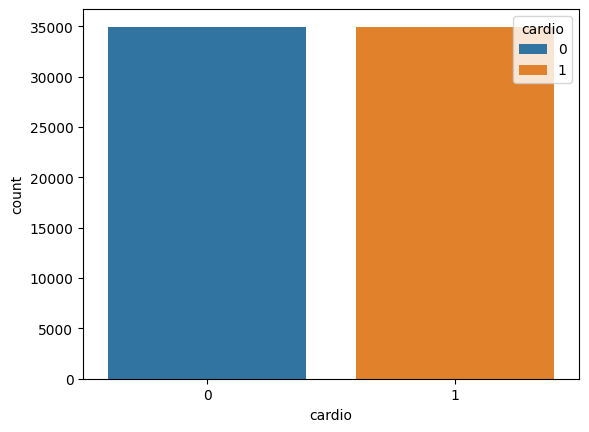

In [34]:
sns.countplot(df, x = "cardio", hue = "cardio")

The dataset looks pretty balanced.

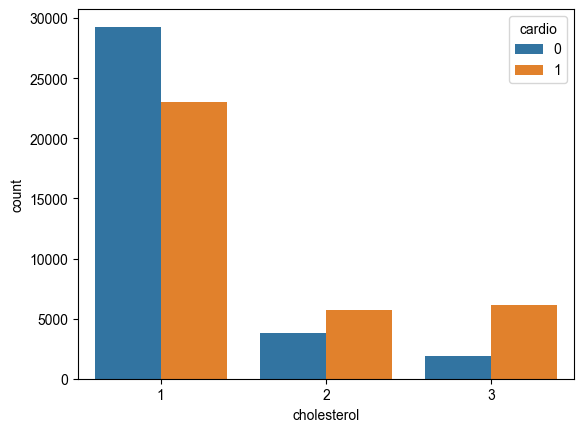

In [35]:
sns.countplot(df, x = "cholesterol", hue = "cardio")
sns.set_style('darkgrid')

In [36]:
df.query("cholesterol == 1")["cholesterol"].count()

52304

In [37]:
print (f"{df.query('cholesterol == 1')['cholesterol'].count() / df['cholesterol'].count() * 100.:1f}% of people in the database have normal cholesterol")
print (f"{df.query('cholesterol == 2')['cholesterol'].count() / df['cholesterol'].count() * 100.:1f}% of people in the database have cholesterol above normal")
print (f"{df.query('cholesterol == 3')['cholesterol'].count() / df['cholesterol'].count() * 100.:1f}% of people in the database have cholesterol which is well above normal")

74.833319% of people in the database have normal cholesterol
13.637794% of people in the database have cholesterol above normal
11.528887% of people in the database have cholesterol which is well above normal


In [38]:
df.columns

Index(['age', 'gender', 'height', 'weight', 'ap_hi', 'ap_lo', 'cholesterol',
       'gluc', 'smoke', 'alco', 'active', 'cardio'],
      dtype='object')

<Axes: ylabel='count'>

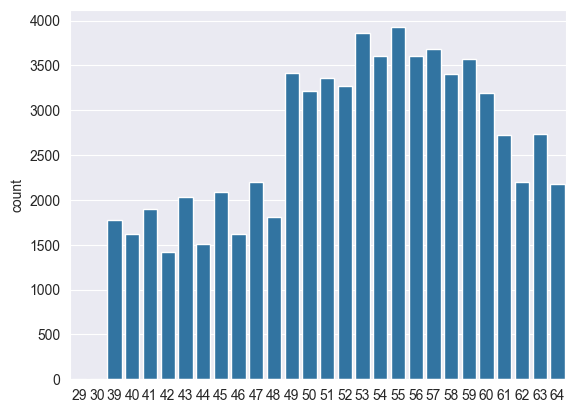

In [39]:
age = [int(value/365) for value in df["age"]]
sns.countplot(x = age)

In [40]:
print (f"The average age is {int(df['age'].mean()/365)}, with the median {int(df['age'].median()/365)} and the mode 55")

The average age is 53, with the median 53 and the mode 55


<Axes: xlabel='smoke', ylabel='count'>

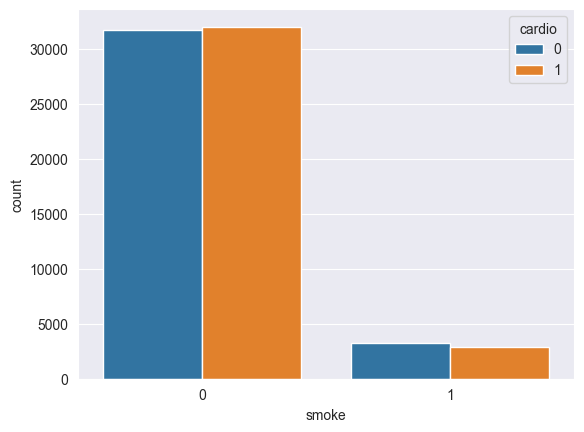

In [41]:
sns.countplot(df, x = "smoke", hue = "cardio")

In [42]:
print (f"{df.query('smoke == 1')['smoke'].count() / df['smoke'].count() * 100.:1f}% of people in the database are smokers")

8.817638% of people in the database are smokers


<Axes: xlabel='weight', ylabel='height'>

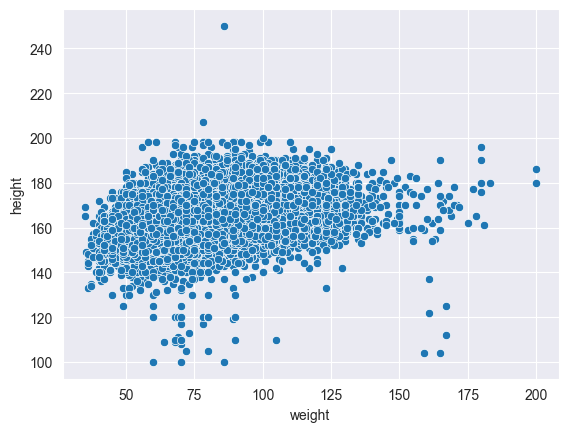

In [43]:
sns.scatterplot(df, x = "weight", y = "height")

In [44]:
df.describe()

age        gender        height        weight         ap_hi  \
count  69894.000000  69894.000000  69894.000000  69894.000000  69894.000000   
mean   19469.161516      1.349587    164.400406     74.219657    127.035568   
std     2466.982884      0.476843      7.990043     14.360540     17.087656   
min    10798.000000      1.000000    100.000000     35.000000     60.000000   
25%    17665.000000      1.000000    159.000000     65.000000    120.000000   
50%    19703.000000      1.000000    165.000000     72.000000    120.000000   
75%    21327.000000      2.000000    170.000000     82.000000    140.000000   
max    23713.000000      2.000000    250.000000    200.000000    240.000000   

              ap_lo   cholesterol          gluc         smoke          alco  \
count  69894.000000  69894.000000  69894.000000  69894.000000  69894.000000   
mean      81.761782      1.366956      1.226572      0.088176      0.053767   
std       10.231216      0.680355      0.572377      0.283553      0.225559   
min       20.000000      1.000000      1.000000      0.000000      0.000000   
25%       80.000000      1.000000      1.000000      0.000000      0.000000   
50%       80.000000      1.000000      1.000000      0.000000      0.000000   
75%       90.000000      2.000000      1.000000      0.000000      0.000000   
max      190.000000      3.000000      3.000000      1.000000      1.000000   

             active        cardio  
count  69894.000000  69894.000000  
mean       0.803674      0.499714  
std        0.397221      0.500003  
min        0.000000      0.000000  
25%        1.000000      0.000000  
50%        1.000000      0.000000  
75%        1.000000      1.000000  
max        1.000000      1.000000

C:\Users\Mary\AppData\Local\Temp\ipykernel_7464\243362388.py:2: UserWarning:

set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.



[Text(0, 0, 'women'), Text(1, 0, 'men')]

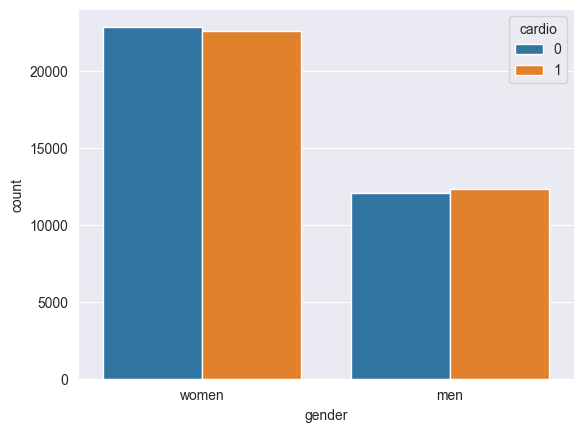

In [45]:
plot = sns.countplot(df, x = "gender", hue = "cardio")
plot.set_xticklabels(['women', 'men'])

In [46]:
print (f"The procent of women having the cardiovascular disease in the dataset (to the total number of women) is {df.query('gender == 1 and cardio ==1')['cardio'].count() / df.query('gender == 1')['cardio'].count() * 100.:1f}%")
print (f"The procent of men having the cardiovascular disease in the dataset (to the total number of men) is {df.query('gender == 2 and cardio ==1')['cardio'].count() / df.query('gender == 2')['cardio'].count() * 100.:1f}%")
print (f"Overall procent of women in the dataset is {df.query('gender == 1')['cardio'].count() / df['cardio'].count() * 100.:1f}%")

The procent of women having the cardiovascular disease in the dataset (to the total number of women) is 49.672239%
The procent of men having the cardiovascular disease in the dataset (to the total number of men) is 50.527953%
Overall procent of women in the dataset is 65.041348%


## Model design

Correlation matrix

<Axes: >

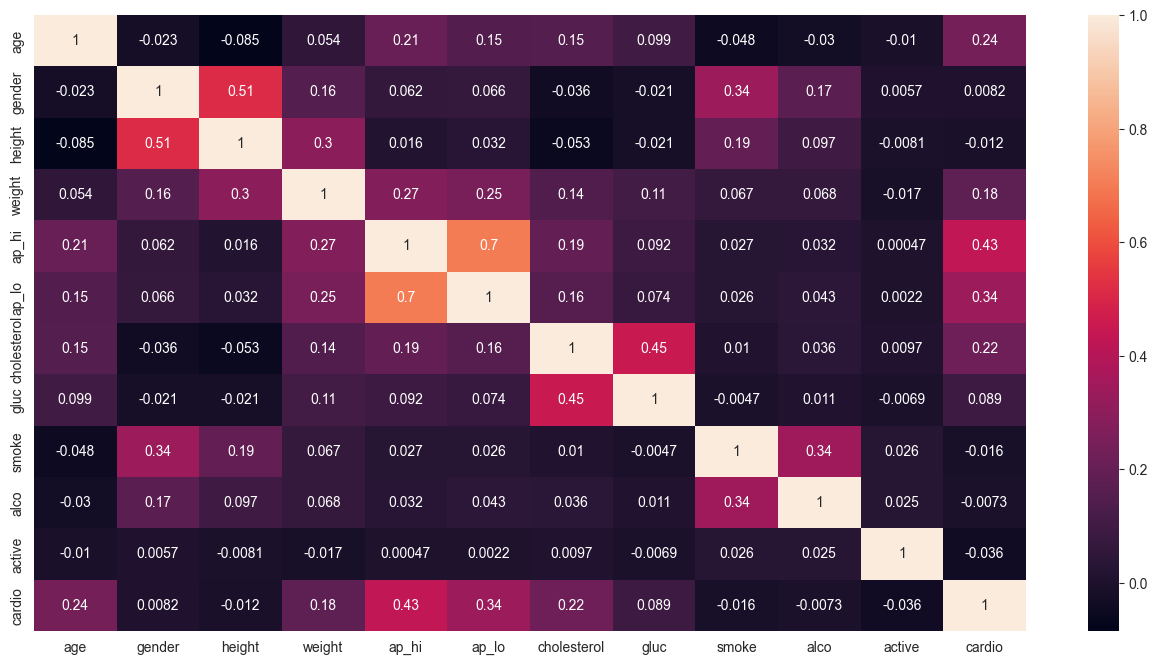

In [47]:
f, ax = plt.subplots(figsize = (16, 8))
sns.heatmap(df.corr(), annot = True)

It seems that the highest influemce on the target varible is of the following factors:
- ap_hi / ap_lo (which are highly correlated themself), with a higher influence of ap_hi (r = 0.43)
- cholesterol (0.22), and there is also an association (r = 0.45) between cholesterol and glucose levels.
- age (0.24)
- weight (0.18)

Other factors seem to be insignificant, showing week or no correlation.

### Feature Engineering

The source of BMI formula and ranges: [Wikipedia](https://en.wikipedia.org/wiki/Body_mass_index)

$BMI = masskg / heightm^2$

**Category 	BMI (kg/m2)**  
Underweight (Severe thinness) 	< 16.0 	  
Underweight (Moderate thinness) 	16.0 – 16.9 	  
Underweight (Mild thinness) 	17.0 – 18.4 	  
Normal range 	18.5 – 24.9 	  
Overweight (Pre-obese) 	25.0 – 29.9 	  
Obese (Class I) 	30.0 – 34.9 	  
Obese (Class II) 	35.0 – 39.9 	  
Obese (Class III) 	≥ 40.0 	  

In [50]:
df['BMI'] = df['weight']/(df['height']/100)**2
df.sample(3)

age  gender  height  weight  ap_hi  ap_lo  cholesterol  gluc  smoke  \
id                                                                             
72937  23272       1     157    86.0    140   80.0            3     1      0   
142    14499       2     164    48.0    110   70.0            1     2      1   
22907  18005       1     166   104.0    110   70.0            2     1      0   

       alco  active  cardio        BMI  
id                                      
72937     0       1       1  34.889854  
142       1       1       1  17.846520  
22907     0       1       0  37.741327

In [52]:
px.box(df['BMI'])

In [61]:
df.query('BMI>60')

age  gender  height  weight  ap_hi  ap_lo  cholesterol  gluc  smoke  \
id                                                                             
552    16718       2     165   169.0    120   80.0            1     1      0   
3470   23646       2     159   165.0    130   70.0            1     1      0   
4672   17545       1     155   155.0    160  110.0            1     1      0   
4825   14585       1     159   159.0    100   80.0            1     1      0   
4838   14516       1     100    70.0    100   70.0            1     1      0   
8757   20990       1     122   161.0    120   80.0            1     1      0   
12381  19698       2     119    89.0    160   90.0            1     1      0   
16062  18307       1     110    90.0    120   80.0            1     1      0   
17757  22077       1     137   161.0    150  100.0            2     1      0   
20970  21135       1     159   153.0    120   80.0            1     1      0   
21958  17405       1     125   167.0    180   90.0            1     2      0   
24396  21259       1     100    86.0    110   70.0            1     1      0   
27063  15421       1     155   163.0    180  100.0            1     1      0   
27962  23193       1     162   162.0    150   90.0            1     1      0   
28605  19777       1     112   167.0    180  120.0            1     1      0   
28683  20656       2     165   178.0    120   80.0            1     1      1   
34317  22013       1     120    90.0    120   80.0            1     1      0   
41289  18961       1     110   105.0    140   90.0            2     1      0   
52564  19630       1     161   181.0    180  110.0            2     1      0   
53389  22051       1     105    72.0    120   70.0            1     3      0   
53670  19909       1     162   175.0    140  110.0            1     1      0   
56496  14606       1     108    70.0    140   90.0            1     1      0   
58175  21728       1     154   162.0    120   80.0            1     1      0   
59768  20464       1     164   164.0    140   90.0            3     3      0   
60631  19450       1     160   155.0    120   80.0            1     1      0   
64802  19834       1     104   159.0    200  100.0            3     1      0   
66494  20453       1     160   158.0    150   90.0            1     1      0   
71945  15117       2     180   200.0    150   90.0            1     1      0   
74028  23228       1     142   129.0    140   90.0            1     3      0   
81878  19708       2     120    90.0    120   90.0            1     1      1   
85128  17643       1     104   165.0    120   80.0            1     1      0   
88220  18956       2     165   178.0    120   80.0            1     1      0   
90930  23483       1     154   155.0    170   80.0            2     1      0   
91284  21115       1     164   164.0    120   80.0            1     1      0   
92301  21705       1     169   172.0    120   70.0            2     1      0   
92478  23476       1     105    80.0    130   90.0            1     1      0   
94906  16928       2     110    90.0    110   90.0            1     1      0   
96921  21763       1     133   123.0    180  100.0            2     1      0   

       alco  active  cardio         BMI  
id                                       
552       0       1       0   62.075298  
3470      0       0       0   65.266406  
4672      0       1       1   64.516129  
4825      0       1       0   62.893082  
4838      0       1       0   70.000000  
8757      0       1       1  108.169847  
12381     0       1       1   62.848669  
16062     0       1       0   74.380165  
17757     0       0       1   85.779743  
20970     0       1       1   60.519758  
21958     0       1       1  106.880000  
24396     0       1       1   86.000000  
27063     0       1       1   67.845994  
27962     0       1       1   61.728395  
28605     1       1       0  133.131378  
28683     1       1       0   65.381084  
34317     0       0       0   62.500000  
41289     

In [60]:
df.query('BMI>60')['BMI'].count()

38

By analyzing the boxplot and also a BMI chart from wikipedia, I decided to remove 38 rows with the BMI > 60 as extreme outliers.

In [62]:
df.drop((df.loc[df.loc[:, 'BMI']>60, :]).index, inplace = True)

In [63]:
df.query('BMI>60')['BMI'].count()

0